In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from datetime import datetime, date
import json
import geopandas as gpd
import requests
import matplotlib.pyplot as plt

In [2]:
# Select modeling domain
domain = 'CHUK'
# data location
datapath = '/nfs/attic/dfh/2020_NPRB/data/'
# SM forcing files 
SMdatapath = datapath+'SMinputs/'+domain+'/'
# dem tif
demtif = SMdatapath+domain+'_dem.tif'

# historical ET data - na
path_hist = '/nfs/attic/dfh/data/climate_na_et/Normal_1991_2020_monthly/'
# future ET data - na
path_fut = '/nfs/attic/dfh/data/climate_na_et/ensemble_8GCMs_ssp585_2071_2100/'
# historical ET data - domain
path_hist_out = datapath+'climate_na_et/Normal_1991_2020_monthly/'+domain+'/'
# future ET data - domain
path_fut_out = datapath+'climate_na_et/ensemble_8GCMs_ssp585_2071_2100/'+domain+'/'

In [3]:
#historic monthly data
histpath = path_hist_out+'historic_monthly_et.nc'
datah = xr.open_dataset(histpath)

In [4]:
# create date timeseries with the date of the middle day of each month 
dateslist = ['12-15-2005','1-15-2006','2-15-2006','3-15-2006','4-15-2006','5-15-2006','6-15-2006',
'7-15-2006','8-15-2006','9-15-2006','10-15-2006','11-15-2006','12-15-2006','1-15-2007']
dates = [datetime.strptime(val, '%m-%d-%Y') for val in dateslist]

In [5]:
# interpolate monthly et for each pixel
etdaily = np.empty([397,len(datah.y),len(datah.x)])

for i in range(len(datah.y)):
    for j in range(len(datah.x)):
        etpx = datah.et.isel(x=j,y=i)
        if np.isnan(np.sum(etpx)) == True:
            etdaily[:,i,j] = [np.nan]*397
        else:
            df = pd.DataFrame({'time': dates, 'et': etpx})
            df = df.set_index('time').resample('D').interpolate(method ='polynomial',order=2)
            etdaily[:,i,j] = df.et.values

In [6]:
# build xarray data array to save out
etdy = xr.DataArray(
    etdaily,
    coords={
        "time":df.index.values,
        "y": datah.y.values,
        "x": datah.x.values,
    },
    dims=["time","y", "x"],
)
# convert to dataset
ds=etdy.to_dataset(name = 'et')
ds

<xarray.Dataset>
Dimensions:  (time: 397, y: 798, x: 763)
Coordinates:
  * time     (time) datetime64[ns] 2005-12-15 2005-12-16 ... 2007-01-15
  * y        (y) float64 2.158e+06 2.158e+06 2.156e+06 ... 1.362e+06 1.362e+06
  * x        (x) float64 -7.435e+05 -7.425e+05 -7.415e+05 ... 1.75e+04 1.85e+04
Data variables:
    et       (time, y, x) float64 nan nan nan nan ... 0.001845 0.001238 0.005479

In [7]:
# select 1 year
ds=ds.sel(time=slice('2006-01-01','2006-12-31'))
ds

<xarray.Dataset>
Dimensions:  (time: 365, y: 798, x: 763)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * y        (y) float64 2.158e+06 2.158e+06 2.156e+06 ... 1.362e+06 1.362e+06
  * x        (x) float64 -7.435e+05 -7.425e+05 -7.415e+05 ... 1.75e+04 1.85e+04
Data variables:
    et       (time, y, x) float64 nan nan nan ... 0.00015 -0.0001607 0.001953

In [8]:
# save as netcdf
path = path_hist_out+'historic_daily_et.nc'
ds.to_netcdf(path)

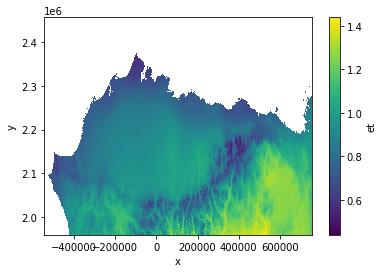

In [8]:
ds.et.mean(dim='time').plot()

## future

In [10]:
# future monthly data
futpath = path_fut_out+'future_monthly_et.nc'
dataf = xr.open_dataset(futpath)

In [11]:
# create date timeseries with the date of the middle day of each month 
dateslist = ['12-15-2005','1-15-2006','2-15-2006','3-15-2006','4-15-2006','5-15-2006','6-15-2006',
'7-15-2006','8-15-2006','9-15-2006','10-15-2006','11-15-2006','12-15-2006','1-15-2007']
dates = [datetime.strptime(val, '%m-%d-%Y') for val in dateslist]

In [12]:
# interpolate monthly et for each pixel
etdaily = np.empty([397,len(dataf.y),len(dataf.x)])

for i in range(len(dataf.y)):
    for j in range(len(dataf.x)):
        etpx = dataf.et.isel(x=j,y=i)
        if np.isnan(np.sum(etpx)) == True:
            etdaily[:,i,j] = [np.nan]*397
        else:
            df = pd.DataFrame({'time': dates, 'et': etpx})
            df = df.set_index('time').resample('D').interpolate(method ='polynomial',order=2)
            etdaily[:,i,j] = df.et.values

In [13]:
# build xarray data array to save out
etdy = xr.DataArray(
    etdaily,
    coords={
        "time":df.index.values,
        "y": dataf.y.values,
        "x": dataf.x.values,
    },
    dims=["time","y", "x"],
)
# convert to dataset
ds=etdy.to_dataset(name = 'et')
ds

<xarray.Dataset>
Dimensions:  (time: 397, y: 798, x: 763)
Coordinates:
  * time     (time) datetime64[ns] 2005-12-15 2005-12-16 ... 2007-01-15
  * y        (y) float64 2.158e+06 2.158e+06 2.156e+06 ... 1.362e+06 1.362e+06
  * x        (x) float64 -7.435e+05 -7.425e+05 -7.415e+05 ... 1.75e+04 1.85e+04
Data variables:
    et       (time, y, x) float64 nan nan nan nan ... 0.03939 0.03911 0.04265

In [14]:
# select 1 year
ds=ds.sel(time=slice('2006-01-01','2006-12-31'))
ds

<xarray.Dataset>
Dimensions:  (time: 365, y: 798, x: 763)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * y        (y) float64 2.158e+06 2.158e+06 2.156e+06 ... 1.362e+06 1.362e+06
  * x        (x) float64 -7.435e+05 -7.425e+05 -7.415e+05 ... 1.75e+04 1.85e+04
Data variables:
    et       (time, y, x) float64 nan nan nan nan ... 0.02365 0.02376 0.02544

In [15]:
# save as netcdf
path = path_fut_out+'future_daily_et.nc'
ds.to_netcdf(path)

In [14]:
ds=xr.open_dataset(path_hist_out+'historic_daily_et.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 365, y: 496, x: 1298)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * y        (y) float64 2.456e+06 2.454e+06 2.454e+06 ... 1.962e+06 1.96e+06
  * x        (x) float64 -5.425e+05 -5.415e+05 ... 7.535e+05 7.545e+05
Data variables:
    et       (time, y, x) float64 ...

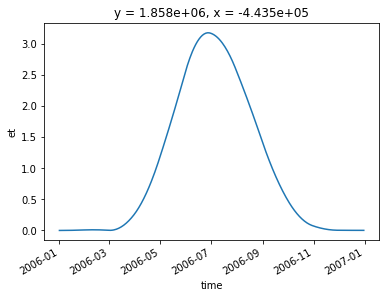

In [9]:
ds.et.isel(y=300,x=300).plot()